In [142]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [143]:
X = torch.tensor([i for i in range(-50, 50)]).float()

In [144]:
def randvec(r1, r2, shape):
    return (r1 - r2) * torch.rand(shape) + r2

In [145]:
y = randvec(-500, 500, X.shape) + X + X.pow(2)

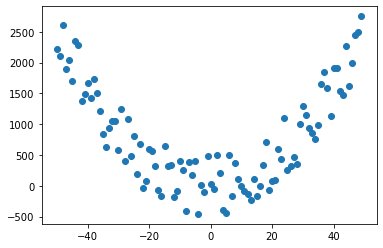

In [146]:
plt.scatter(X, y)

In [147]:
def mse(y_true, y_pred):
    (y_true - y_pred).pow(2).mean()

In [148]:
def create_features(X, degree=2):
    features = []
    for i in range(1, degree + 1):
        X_d = X.pow(i)
        X_d = X_d - X_d.mean() / X_d.std()
        features.append(X_d)
    return features

In [149]:
features = create_features(X)

In [158]:
def get_weights_col(X):
    return torch.normal(torch.zeros(X.shape[0]), torch.ones(X.shape[0])).unsqueeze(1)

def create_weights(X, degree):
    weights = get_weights_col(X)
    for i in range(1, degree):
        weights = torch.cat([weights, get_weights_col(X)], axis=1)
    return weights

In [160]:
weights = create_weights(X, 2)